In [ ]:
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip"
output_path = "wisdm-dataset.zip"

# Download the zip file
response = requests.get(url)
with open(output_path, "wb") as f:
    f.write(response.content)

In [ ]:
!mkdir -p /content/data

In [ ]:
!unzip wisdm-dataset.zip -d /content/data/

Archive:  wisdm-dataset.zip
   creating: /content/data/wisdm-dataset/
  inflating: /content/data/wisdm-dataset/WISDM-dataset-description.pdf  
   creating: /content/data/wisdm-dataset/arffmagic-master/
  inflating: /content/data/wisdm-dataset/arffmagic-master/Makefile  
  inflating: /content/data/wisdm-dataset/arffmagic-master/.DS_Store  
 extracting: /content/data/wisdm-dataset/arffmagic-master/README.md  
   creating: /content/data/wisdm-dataset/arffmagic-master/src/
  inflating: /content/data/wisdm-dataset/arffmagic-master/src/arff.cpp  
  inflating: /content/data/wisdm-dataset/arffmagic-master/src/comparator.h  
  inflating: /content/data/wisdm-dataset/arffmagic-master/src/chunk.h  
  inflating: /content/data/wisdm-dataset/arffmagic-master/src/main.cpp  
  inflating: /content/data/wisdm-dataset/arffmagic-master/src/attribute.h  
  inflating: /content/data/wisdm-dataset/arffmagic-master/src/libmfcc.c  
  inflating: /content/data/wisdm-dataset/arffmagic-master/src/raw.h  
  inflating

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [ ]:
spark = SparkSession.builder.appName("WISDM‑Preprocess").getOrCreate()

In [ ]:
schema = T.StructType([
    T.StructField("subject_id",  T.StringType(), True),
    T.StructField("activity",    T.StringType(), True),
    T.StructField("timestamp",   T.LongType(),   True),
    T.StructField("x",           T.DoubleType(), True),
    T.StructField("y",           T.DoubleType(), True),
    T.StructField("z_raw",       T.StringType(), True),    # z has a trailing semicolon
])

In [ ]:
def read_sensor_file(filepath, device_name):
    df = (
        spark.read
             .option("header", "false")
             .schema(schema)
             .csv(filepath)
             .na.drop()
             .withColumn("z",
                         F.regexp_replace("z_raw", r'[^0-9\.\-]', "")
                         .cast("double"))
             .drop("z_raw")
             .withColumn("timestamp", F.col("timestamp").cast("long"))
             .withColumn("device", F.lit((0 if device_name == 'phone' else 1)))
      )
    return df

def create_common_timestamp_grid(start, end, freq_hz):
    duration = (end - start) / 1e9
    num_samples = int(duration * freq_hz)
    return np.linspace(start, end, num_samples)

def interpolate_sensor_block(df, timestamps):
    interp = {}
    for axis in ['x', 'y', 'z']:
        f = interp1d(df['timestamp'], df[axis], kind='linear', fill_value="extrapolate")
        interp[axis] = f(timestamps)
    return interp

def create_labeled_windows(features, label, device_name, window_size, step_size):
    X, y, device = [], [], []
    for i in range(0, len(features) - window_size + 1, step_size):
        X.append(features[i:i+window_size])
        y.append(label)
        device.append(device_name)
    return X, y, device

In [ ]:
base_dir = os.getcwd() + "/data/"

filenames = []

for device_name in ['phone', 'watch']:
    for sensor_type in ['accel', 'gyro']:
        if not os.path.join(base_dir, device_name, sensor_type):
            continue

filenames = sorted(f for f in os.listdir(os.path.join(base_dir, device_name, 'accel')) if f.endswith('.txt'))

filenames[:10]

['data_1600_accel_watch.txt']

In [ ]:
for filename in filenames[:1]:
    subj_id = filename.split("_")[1]
    accel_path = os.path.join(base_dir, device_name, "accel", f"data_{subj_id}_accel_{device_name}.txt")
    gyro_path  = os.path.join(base_dir, device_name, "gyro", f"data_{subj_id}_gyro_{device_name}.txt")

    if not os.path.exists(accel_path) or not os.path.exists(gyro_path):
        continue

    accel_df = read_sensor_file(accel_path, device_name)
    gyro_df  = read_sensor_file(gyro_path, device_name)

In [ ]:
accel_df.printSchema()

root
 |-- subject_id: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- device: integer (nullable = false)



In [ ]:
common_activities = common_acts = (set(accel_df.select('activity').distinct().toPandas()['activity'])
                               & set(gyro_df.select('activity').distinct().toPandas()['activity']))
common_activities

{'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'O',
 'P',
 'Q',
 'R',
 'S'}

In [ ]:
window_size = 100
freq_hz = 50
step_size = 50
X = []
y = []
devices = []

for activity in ['A']:
    acc_block = accel_df.filter(F.col("activity") == activity)
    gyr_block = gyro_df .filter(F.col("activity") == activity)

    if acc_block.count() < 2 or gyr_block.count() < 2:
        continue

    start = max(acc_block.agg(F.min("timestamp")).first()[0],
                gyr_block .agg(F.min("timestamp")).first()[0])
    end   = min(acc_block.agg(F.max("timestamp")).first()[0],
                gyr_block .agg(F.max("timestamp")).first()[0])

    if end - start < 1e9:
        continue

    acc_pdf = (acc_block
               .filter((F.col("timestamp") >= start) & (F.col("timestamp") <= end))
               .orderBy("timestamp")
               .toPandas())
    gyr_pdf = (gyr_block
               .filter((F.col("timestamp") >= start) & (F.col("timestamp") <= end))
               .orderBy("timestamp")
               .toPandas())

    timestamps = create_common_timestamp_grid(start, end, freq_hz)

    acc_i = interpolate_sensor_block(acc_pdf, timestamps)
    gyr_i = interpolate_sensor_block(gyr_pdf, timestamps)

    features = np.stack([
        acc_i['x'], acc_i['y'], acc_i['z'],
        gyr_i['x'], gyr_i['y'], gyr_i['z']
    ], axis=1)

    device_id = 0 if device_name == 'phone' else 1

    X_seqs, Y_seqs, device_seqs = create_labeled_windows(features, activity, device_id, window_size, step_size)
    X.extend(X_seqs)
    y.extend(Y_seqs)
    devices.extend(device_seqs)

In [ ]:
len(devices)

178

In [ ]:
def plot_interpolation_comparison(
        t_raw,           # 1‑D array of original timestamps (ns or s)
        v_raw,           # 1‑D array of original sensor values
        t_interp,        # 1‑D array of new (uniform) timestamps
        v_interp,        # 1‑D array of interpolated values
        axis_name="accel_x",
        units="g"
    ):
    """
    Plot original vs. interpolated signal and the absolute error.
    """

    # --- Figure layout ------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex=True, figsize=(10, 5),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Top: overlay -------------------------------------------------------
    ax1.scatter(t_raw, v_raw, color="black", s=12, label="raw", zorder=3)
    ax1.plot(t_interp, v_interp, color="tab:blue", lw=2, label="interpolated")
    ax1.set_ylabel(f"{axis_name}  ({units})")
    ax1.set_title(f"Interpolation check – {axis_name}")
    ax1.legend()

    # --- Bottom: error ------------------------------------------------------
    # Interpolate raw values on the new grid to compute error at same points
    raw_on_grid = np.interp(t_interp, t_raw, v_raw)
    abs_err = np.abs(raw_on_grid - v_interp)

    ax2.plot(t_interp, abs_err, color="tab:red", lw=1)
    ax2.set_ylabel("abs. error")
    ax2.set_xlabel("time  (same units as input)")
    ax2.set_ylim(0, abs_err.max() * 1.1)

    fig.tight_layout()
    plt.show()


In [ ]:
timestamps_raw = [timestamp['timestamp'] for timestamp in acc_block.select('timestamp').collect()]
x_raw = [x['x'] for x in acc_block.select('x').collect()]
len(x_raw)

3605

<ipython-input-141-d9fd6b7b4620>:34: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(0, abs_err.max() * 1.1)


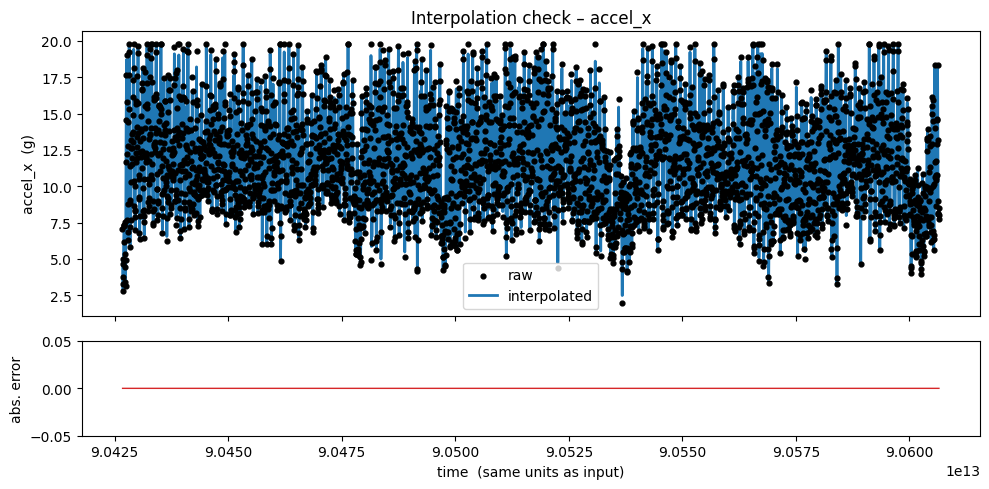

In [ ]:
plot_interpolation_comparison(timestamps_raw, x_raw, timestamps, acc_i['x'])

In [ ]:
class WISDMUnifiedDataset(Dataset):
    """
    Returns: sequence (T,6),  integer_activity,  integer_device
             device: 0=phone, 1=watch
    """
    def __init__(self, base_dir='/data/', hz=50, win=100, step=50):
        self.X, self.y, self.dev = [], [], []

        self.X = X
        self.y = y
        self.dev = devices
        label_set = list(common_activities)


        # ----- label mapping -----
        self.class_names = sorted(label_set)            # e.g. ['A', …, 'S']
        self.name2idx = {n:i for i,n in enumerate(self.class_names)}
        self.idx2name = {i:n for n,i in self.name2idx.items()}
        self.num_classes = len(self.class_names)


        # map char labels to int
        self.y = [self.name2idx[n] for n in self.y]

        # convert to tensors
        self.X = torch.tensor(np.stack(self.X).astype(np.float32))
        self.y = torch.tensor(self.y, dtype=torch.long)
        self.dev = torch.tensor(self.dev, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        print("here", self.dev.shape)
        return self.X[idx], self.y[idx], self.dev[idx]

In [ ]:
ds = WISDMUnifiedDataset()
print(ds.X.shape)
print(ds.num_classes)        # 19
print(ds.class_names[:5])    # ['A','B','C','D','E']
print(len(ds))

seq, label, device = ds[0]
print(seq.shape)             # (100, 6)
print(label, ds.idx2name[label.item()])   # e.g., 3  -> 'D'
print(device)                # 0 or 1


torch.Size([178, 100, 6])
18
['A', 'B', 'C', 'D', 'E']
178
here torch.Size([178])
torch.Size([100, 6])
tensor(0) A
tensor(1)


In [4]:
from pyspark.sql import SparkSession, functions as F, types as T
import os, random, numpy as np
from scipy.interpolate import interp1d
import math

# 1) SETUP -------------------------------------------------------------------
spark = SparkSession.builder.appName("WISDM_Split_Preproc").config("spark.driver.memory", "10g").getOrCreate()

# Change to your data root
BASE = "/content/data/wisdm-dataset/raw"
PHONE_ACC = os.path.join(BASE, "phone/accel")
PHONE_GYR = os.path.join(BASE, "phone/gyro")
WATCH_ACC = os.path.join(BASE, "watch/accel")
WATCH_GYR = os.path.join(BASE, "watch/gyro")

# 2) DISCOVER SUBJECTS -------------------------------------------------------
# assume filenames like "001_accel.txt"
all_subs = sorted({f.split("_")[1]
                   for f in os.listdir(PHONE_ACC) if f.endswith(".txt")})
random.seed(42)
random.shuffle(all_subs)

n = len(all_subs)
n_train = math.ceil(0.8 * n)
n_val   = math.floor(0.1 * n)

train_subs = set(all_subs[:n_train])
val_subs   = set(all_subs[n_train:n_train+n_val])
test_subs  = set(all_subs[n_train+n_val:])

print("all subs", n)
print(f"Train subjects: {len(train_subs)}, Val: {len(val_subs)}, Test: {len(test_subs)}")

all subs 51
Train subjects: 41, Val: 5, Test: 5


In [5]:
# 3) COMMON FUNCTIONS --------------------------------------------------------
# schema & loader
schema = T.StructType([
    T.StructField("subject_id",   T.StringType(), True),
    T.StructField("activity",  T.StringType(), True),
    T.StructField("timestamp", T.LongType(),   True),
    T.StructField("x",         T.DoubleType(), True),
    T.StructField("y",         T.DoubleType(), True),
    T.StructField("z_raw",     T.StringType(), True),
])

def read_sensor(path):
    return (
        spark.read
             .option("header", "false")
             .schema(schema)
             .csv(path)
             .na.drop()
             .withColumn("z",
                         F.regexp_replace("z_raw", r'[^0-9\.\-]', "")
                         .cast("double"))
             .drop("z_raw")
             .withColumn("timestamp", F.col("timestamp").cast("long"))
      )

def create_grid(start, end, hz):
    dur = (end - start) / 1e9
    n  = int(dur * hz)
    return np.linspace(start, end, n)

def interp_block(pdf, ts):
    global df
    df = pdf
    out = {}
    for ax in ["x","y","z"]:
        f = interp1d(pdf["timestamp"], pdf[ax], kind="linear", fill_value="extrapolate")
        out[ax] = f(ts)
    return out

def slide_windows(mat, label, device, win=100, step=50):
    rows = []
    for i in range(0, len(mat)-win+1, step):
        window = mat[i:i+win].flatten().tolist()
        rows.append((window, label, device))
    return rows

# 4) PROCESS & SPLIT --------------------------------------------------------
def process_subjects(subject_set, device_name, device_id):
    """
    Returns list of (features_list, label_str, device_id) rows
    """
    rows = []
    acc_dir = os.path.join(BASE, device_name, "accel")
    gyr_dir = os.path.join(BASE, device_name, "gyro")

    for sid in subject_set:
        print(f"\nProcessing subject {sid}...")
        acc_path = os.path.join(acc_dir, f"data_{sid}_accel_{device_name}.txt")
        gyr_path = os.path.join(gyr_dir, f"data_{sid}_gyro_{device_name}.txt")
        if not os.path.exists(acc_path) or not os.path.exists(gyr_path):
            print("[ERROR] path doesn't exist")
            continue

        acc_df = read_sensor(acc_path)
        gyr_df = read_sensor(gyr_path)

        acts = (set(r.activity for r in acc_df.select("activity").distinct().collect())
                & set(r.activity for r in gyr_df.select("activity").distinct().collect()))

        for act in acts:
            print(f"Processing activity {act} for subj {sid}...")
            a = acc_df.filter(F.col("activity")==act).toPandas().sort_values("timestamp").drop_duplicates(subset="timestamp")
            g = gyr_df.filter(F.col("activity")==act).toPandas().sort_values("timestamp").drop_duplicates(subset="timestamp")

            if len(a)<2 or len(g)<2:
                continue

            start = max(a.timestamp.min(), g.timestamp.min())
            end   = min(a.timestamp.max(), g.timestamp.max())
            if end - start < 1_000_000_000:  # <1s overlap
                continue

            ts = create_grid(start, end, hz=50)
            ai = interp_block(a, ts)
            gi = interp_block(g, ts)

            feat = np.stack([ai["x"], ai["y"], ai["z"], gi["x"], gi["y"], gi["z"]], axis=1)
            rows.extend(slide_windows(feat, act, device_id, win=100, step=50))

    return rows

In [6]:
# run for train+val, then split rows by subject belonging
train_rows = []
val_rows   = []

for dev, d_id in [("phone", 0), ("watch", 1)]:
    print(f"\n==============Processing subjects for device {dev}=============")
    tr = process_subjects(train_subs, dev, d_id)
    vr = process_subjects(val_subs,   dev, d_id)
    train_rows.extend(tr)
    val_rows.extend(vr)


==============Processing subjects for device phone=============

Processing subject 1648...
Processing activity E for subj 1648...
Processing activity P for subj 1648...
Processing activity A for subj 1648...
Processing activity D for subj 1648...
Processing activity O for subj 1648...
Processing activity I for subj 1648...
Processing activity C for subj 1648...
Processing activity Q for subj 1648...
Processing activity L for subj 1648...
Processing activity G for subj 1648...
Processing activity B for subj 1648...
Processing activity H for subj 1648...
Processing activity M for subj 1648...
Processing activity S for subj 1648...
Processing activity R for subj 1648...
Processing activity F for subj 1648...
Processing activity K for subj 1648...
Processing activity J for subj 1648...

Processing subject 1633...
Processing activity E for subj 1633...
Processing activity P for subj 1633...
Processing activity A for subj 1633...
Processing activity D for subj 1633...
Processing activity O

In [7]:
len(train_rows), len(val_rows)

(259519, 32040)

In [8]:
spark.stop()

In [9]:
spark = SparkSession.builder.appName("WISDM_Split_Preproc").config("spark.driver.memory", "10g").getOrCreate()

In [10]:
# 5) SAVE TO PARQUET ---------------------------------------------------------
# convert to DataFrame and write
from pyspark.sql import Row
def rows_to_df(rows):
    # schema: features: array<double>, label: string, device: int
    return spark.createDataFrame(
        [Row(features=r[0], label=r[1], device=r[2]) for r in rows]
    )

slice_size = 10_000
part = 0
for i in range(0, len(train_rows), slice_size):
  print(f"Saving train part {part:03d}, rows {i}-{i+slice_size-1}")
  rows_to_df(train_rows[i: i+slice_size]).write.mode("overwrite").parquet(f"preproc/train_data_{part:03d}.parquet")
  part += 1

rows_to_df(val_rows).write.mode("overwrite").parquet("preproc/val_data.parquet")

print("Train & Val windows written to parquet.")
print("Test subjects held out for Kafka streaming:", sorted(test_subs))

spark.stop()

Saving train part 000, rows 0-9999
Saving train part 001, rows 10000-19999
Saving train part 002, rows 20000-29999
Saving train part 003, rows 30000-39999
Saving train part 004, rows 40000-49999
Saving train part 005, rows 50000-59999
Saving train part 006, rows 60000-69999
Saving train part 007, rows 70000-79999
Saving train part 008, rows 80000-89999
Saving train part 009, rows 90000-99999
Saving train part 010, rows 100000-109999
Saving train part 011, rows 110000-119999
Saving train part 012, rows 120000-129999
Saving train part 013, rows 130000-139999
Saving train part 014, rows 140000-149999
Saving train part 015, rows 150000-159999
Saving train part 016, rows 160000-169999
Saving train part 017, rows 170000-179999
Saving train part 018, rows 180000-189999
Saving train part 019, rows 190000-199999
Saving train part 020, rows 200000-209999
Saving train part 021, rows 210000-219999
Saving train part 022, rows 220000-229999
Saving train part 023, rows 230000-239999
Saving train part

In [19]:
del train_rows
del val_rows

In [1]:
import numpy as np
import torch
from torch.utils.data import IterableDataset, DataLoader
from pyspark.sql import SparkSession, functions as F
import glob

class SparkShuffledParquetDataset(IterableDataset):
    def __init__(self, parquet_path, window_size=100, num_features=6):
        self.parquet_path = parquet_path
        self.window_size  = window_size
        self.num_features = num_features
        # Create one SparkSession per process
        self.spark = SparkSession.builder \
            .appName("WISDM-SparkLoader") \
            .getOrCreate()
        paths = glob.glob("preproc/train_*.parquet")
        self.df = ( self.spark
                .read
                .parquet(*paths)
        )

        label_set = set(self.df.select('label').distinct().toPandas()['label'])
        self.class_names = sorted(label_set)            # e.g. ['A', …, 'S']
        self.name2idx = {n:i for i,n in enumerate(self.class_names)}
        self.idx2name = {i:n for n,i in self.name2idx.items()}
        self.num_classes = len(self.class_names)

    def __len__(self):
      return self.df.count()

    def __iter__(self):
        print("iter calling")
        # 1) Read + shuffle in Spark
        df = self.df.orderBy(F.rand())                # global shuffle each epoch
        # 2) Stream rows partition-by-partition
        for row in df.toLocalIterator():
            flat = np.array(row.features, dtype=np.float32)
            seq  = flat.reshape(self.window_size, self.num_features)
            yield torch.from_numpy(seq), torch.tensor(self.name2idx[row.label]), torch.tensor(row.device)

In [2]:
dataset = SparkShuffledParquetDataset(
    parquet_path="preproc/train_data_000.parquet",
    window_size=100,
    num_features=6
)

In [3]:
len(dataset)

259519

In [4]:
from tqdm import tqdm

loader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=0,    # Spark sessions aren’t fork‐safe
    pin_memory=True
)

num_epochs = 1
num_batches = len(dataset) // 32

for epoch in range(num_epochs):
    for x, y, d in tqdm(loader,
                        total=num_batches,
                        desc=f"Epoch {epoch+1}/{num_epochs}",
                        leave=False):
        # x: (batch, 100, 6), y: (batch,), d: (batch,)
        pass
        # … your training step …
    # next epoch → __iter__ called again → fresh Spark shuffle


Epoch 1/1:   0%|          | 0/8109 [00:00<?, ?it/s]

iter calling


KeyboardInterrupt: 

In [15]:
!zip -r prepoc.zip /content/preproc/

  adding: content/preproc/ (stored 0%)
  adding: content/preproc/train_data_001.parquet/ (stored 0%)
  adding: content/preproc/train_data_001.parquet/.part-00000-d71ad22a-0877-49c8-a26e-f3868aaf0e0e-c000.snappy.parquet.crc (deflated 0%)
  adding: content/preproc/train_data_001.parquet/._SUCCESS.crc (stored 0%)
  adding: content/preproc/train_data_001.parquet/.part-00001-d71ad22a-0877-49c8-a26e-f3868aaf0e0e-c000.snappy.parquet.crc (deflated 0%)
  adding: content/preproc/train_data_001.parquet/part-00000-d71ad22a-0877-49c8-a26e-f3868aaf0e0e-c000.snappy.parquet (deflated 23%)
  adding: content/preproc/train_data_001.parquet/part-00001-d71ad22a-0877-49c8-a26e-f3868aaf0e0e-c000.snappy.parquet (deflated 23%)
  adding: content/preproc/train_data_001.parquet/_SUCCESS (stored 0%)
  adding: content/preproc/train_data_012.parquet/ (stored 0%)
  adding: content/preproc/train_data_012.parquet/.part-00001-59298a99-b5ce-4b49-9584-ea190ae776c3-c000.snappy.parquet.crc (deflated 0%)
  adding: content/pr

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
!mkdir -p "/content/drive/My Drive/Colab Notebooks/big-data-project/data"

In [18]:
! cp /content/prepoc.zip  "/content/drive/My Drive/Colab Notebooks/big-data-project/data"